# Creating a Custom Callback in Keras

In this project, we will create a custom callback function and use it in a model training process. We will write the callback to perform three tasks.

1. Write a log file on disk and update it with the training matrix from during the training process.
2. Update the value for learning rate for each epoch.
3. Plot the training and validation accuracies in a graph during the training process.

While keras comes with a variety of callbacks already implemented, which can be used for learning rate, scheduling and logging. It's worth exploring how to create custom functionality by going through the process of implementing a new call back and using it during model training.

# 1. Importing Libraries

In [1]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)
# Here, we'll be using Keras with the tf backend. Or the TF implementation of keras.

TensorFlow version: 2.5.0


# 2. Importing and Preprocessing Data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.reshape(x_train, (60000, 784))/255.
x_test = np.reshape(x_test, (10000, 784))/255.

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print(x_train.shape, y_train.shape) #60k examples - each example is a vector of 784 dimensions & 60K labels - each label is a 10 dimensional vector.

(60000, 784) (60000, 10)


# 3. Creating the Model

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(784,)),
    tf.keras.layers.Dense(10, activation='softmax')
])

opt = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
_________________________________________________________________


# 4. Creating the Callback

In [4]:
class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, fraction):
        super(CustomCallback, self).__init__()
        
        self.fraction = fraction
        self.train_a = []
        self.val_a = []
        
        with open('log.txt', 'w') as f:
            f.write('Start of log\n')
        
        self.fig = plt.figure(figsize=(4, 3))
        self.ax = plt.subplot(1, 1, 1) #1 row, 1 column, and first axis of that subplot
        plt.ion() # Setting pyplot interactive mode ON
    
    def on_train_begin(self, logs=None):
        self.fig.show()
        self.fig.canvas.draw()
    
    def on_train_end(self, logs=None):
        with open('log.txt', 'a') as f:
            f.write('End of log\n')
    
    def on_epoch_begin(self, epoch, logs=None):
        lr = self.fraction * tf.keras.backend.get_value(self.model.optimizer.lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, lr) #Learning rate scheduling
        with open('log.txt', 'a') as f:
            f.write('At epoch:{:02d}, Learning Rate changed to:{:.4f}, '.format(epoch, lr))
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        
        self.train_a.append(train_acc)
        self.val_a.append(val_acc)
        
        with open('log.txt', 'a') as f:
            f.write('At epoch {:02d}, Train Acc:{:.3f}, Val Acc:{:.3f}\n'.format(epoch, train_acc , val_acc))
        
        self.ax.clear()
        self.ax.plot(range(epoch + 1), self.train_a, label='Training Acc') #List updation after each epoch
        self.ax.plot(range(epoch + 1), self.val_a, label='Validation Acc')
        self.ax.set_xlabel('Epochs')
        self.ax.set_ylabel('Accuracy')
        self.ax.legend()
        self.fig.canvas.draw()

# 5. Training the Model

<IPython.core.display.Javascript object>


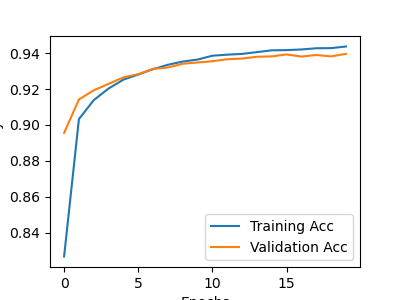

In [5]:
cc = CustomCallback(fraction=0.9)

In [6]:
_ = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=20, verbose=False,
    callbacks=[cc]
)

# On console: Get-content .\log.txt -Wait